In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [37]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

query = {"$and": [{"tags": "data-efficiency"},
                  {"state": "finished"},
                  {"config.n_train": 800},
                  {"config.body_args": [5]},
                  {"config.network_class": "HNN"}
                 ]}

runs, histories = zip(*get_history(query=query))
hnn_trainer, hnn_model = load_model_from_run(runs[0])

query = {"$and": [{"tags": "data-efficiency"},
                  {"state": "finished"},
                  {"config.n_train": 800},
                  {"config.body_args": [5]},
                  {"config.network_class": "CHNN"}
                 ]}

runs, histories = zip(*get_history(query=query))
chnn_trainer, chnn_model = load_model_from_run(runs[0])

INFO:lightning:GPU available: True, used: False


tensor(7.1316e-06, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f2c1ec98c10>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/HNN/wandb/run-20200506_160135-7bze4jkz/constrained-pnns/version_7bze4jkz/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 5,
    'dt': 0.1,
    'euclidean': False,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/HNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    'logger': <pytorch_lightning.loggers

INFO:lightning:GPU available: True, used: False


CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 5),
    'batch_size': 800,
    'body_args': [5],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f2c1edd0810>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CHNN/wandb/run-20200506_222109-2d3zj9wh/constrained-pnns/version_2d3zj9wh/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn5m1l1/CHNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0,
    '

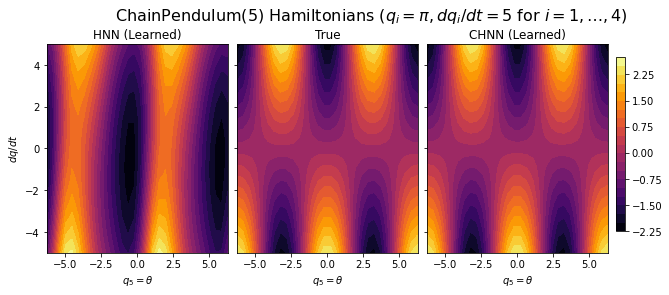

In [73]:
import torch
import math

n_dof = runs[0].config["body_args"][0]
D = 2 # ambient dimension
n_per_dim = 30

q_vary = torch.linspace(-2 * math.pi, 2 * math.pi, n_per_dim)
qdot_vary = torch.linspace(-5, 5, n_per_dim)
q_vary, qdot_vary = torch.meshgrid(q_vary, qdot_vary)

q_fixed = math.pi * torch.ones_like(q_vary)
qdot_fixed = 5 * torch.ones_like(qdot_vary)

# Turn into N1 x N2 x ndof
if n_dof == 1: # 1 pendulum
    q = q_vary.reshape(n_per_dim, n_per_dim, n_dof)
    qdot = qdot_vary.reshape(n_per_dim, n_per_dim, n_dof)
elif n_dof == 2: # 2 pendulum
    q = torch.stack([q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_vary], dim=-1)
elif n_dof == 3: # 3 pendulum
    q = torch.stack([q_fixed, q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_vary], dim=-1)
elif n_dof == 5: # 3 pendulum
    q = torch.stack([q_fixed, q_fixed, q_fixed, q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_fixed, qdot_fixed, qdot_vary], dim=-1)

# Turn into N1*N2 x 2 x ndof
qqdot = torch.stack([q, qdot], dim=-2).reshape(n_per_dim * n_per_dim, 2, n_dof)

# Turn into N1*N2 x 2 x ndof x D
xxdot = hnn_model.body.body2globalCoords(qqdot)
x, xdot = xxdot.chunk(2, dim=1)

with torch.no_grad():
    # Turn into N1*N2 x ndof
    hnn_q = q.reshape(n_per_dim * n_per_dim, n_dof)
    hnn_p = hnn_model.model.M(hnn_q)(
        qdot.reshape(n_per_dim * n_per_dim, n_dof)
    )
    # Turn into N1*N2 x 2*ndof
    hnn_qp = torch.cat([hnn_q, hnn_p], dim=-1)
    hnn_energies = hnn_model.model.H(torch.tensor(0.), hnn_qp)
    hnn_energies -= hnn_energies.mean()
    hnn_energies /= hnn_energies.std()
    hnn_energies = hnn_energies.reshape(n_per_dim, n_per_dim)
    
    true_p_euc = hnn_model.body.M @ xdot.double()
    true_xp_euc = torch.cat([x.double(), true_p_euc], dim=1)
    true_xp_euc = true_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    true_energies = hnn_model.body.hamiltonian(None, true_xp_euc)
    true_energies -= true_energies.mean()
    true_energies /= true_energies.std()
    true_energies = true_energies.reshape(n_per_dim, n_per_dim)

    chnn_p_euc = chnn_model.model.M @ xdot
    # Turn into N1*N2 x 2*ndof*D
    chnn_xp_euc = torch.cat([x, chnn_p_euc], dim=1)
    chnn_xp_euc = chnn_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    chnn_energies = chnn_model.model.H(torch.tensor(0.), chnn_xp_euc)
    chnn_energies -= chnn_energies.mean()
    chnn_energies /= chnn_energies.std()
    chnn_energies = chnn_energies.reshape(n_per_dim, n_per_dim)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(3 * 4, 4))

axes[0].contourf(q_vary, qdot_vary, hnn_energies, cmap="inferno", levels=20)
axes[0].set(title="HNN (Learned)")
axes[0].set(xlabel=r"$q_5 = \theta$")
axes[0].set(ylabel=r"$dq_5/dt$")

axes[1].contourf(q_vary, qdot_vary, true_energies, cmap="inferno", levels=20)
axes[1].set(title="True")
axes[1].set(yticklabels=[])
axes[1].set(xlabel=r"$q_5 = \theta$")

heatmap = axes[2].contourf(q_vary, qdot_vary, chnn_energies, cmap="inferno", levels=20)
axes[2].set(title="CHNN (Learned)")
axes[2].set(yticklabels=[])
axes[2].set(xlabel=r"$q_5 = \theta$")

cbar = fig.colorbar(heatmap, ax=axes.ravel().tolist(), shrink=0.8)
fig.suptitle("ChainPendulum("+ f"{n_dof}" + ") Hamiltonians " 
             + r"($q_i = \pi, dq_i/dt = 5$ for $i = 1,\ldots, 4$)"
             , fontsize=16)
fig.subplots_adjust(top=0.85, right=0.774, wspace=0.05)

In [74]:
fig.savefig("learned-hamiltonian.pdf", bbox_inches="tight")

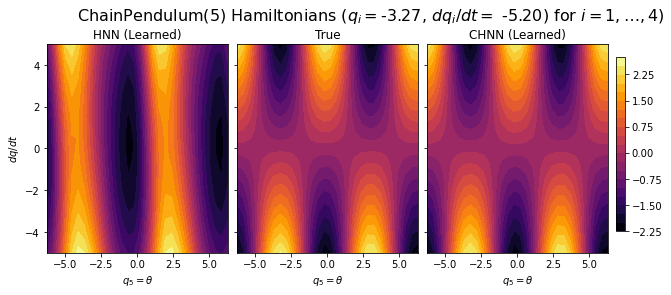

In [169]:
import torch
import math

import matplotlib.pyplot as plt

n_dof = runs[0].config["body_args"][0]
D = 2 # ambient dimension
n_per_dim = 30

q_vary = torch.linspace(-2 * math.pi, 2 * math.pi, n_per_dim)
qdot_vary = torch.linspace(-5, 5, n_per_dim)
q_vary, qdot_vary = torch.meshgrid(q_vary, qdot_vary)

q_fixed = -math.pi * torch.ones_like(q_vary)
qdot_fixed = -5 * torch.ones_like(qdot_vary)

# Turn into N1 x N2 x ndof
if n_dof == 1: # 1 pendulum
    q = q_vary.reshape(n_per_dim, n_per_dim, n_dof)
    qdot = qdot_vary.reshape(n_per_dim, n_per_dim, n_dof)
elif n_dof == 2: # 2 pendulum
    q = torch.stack([q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_vary], dim=-1)
elif n_dof == 3: # 3 pendulum
    q = torch.stack([q_fixed, q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_vary], dim=-1)
elif n_dof == 5: # 3 pendulum
    q = torch.stack([q_fixed, q_fixed, q_fixed, q_fixed, q_vary], dim=-1)
    qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_fixed, qdot_fixed, qdot_vary], dim=-1)

# Turn into N1*N2 x 2 x ndof
qqdot = torch.stack([q, qdot], dim=-2).reshape(n_per_dim * n_per_dim, 2, n_dof)

# Turn into N1*N2 x 2 x ndof x D
xxdot = hnn_model.body.body2globalCoords(qqdot)
x, xdot = xxdot.chunk(2, dim=1)

with torch.no_grad():
    # Turn into N1*N2 x ndof
    hnn_q = q.reshape(n_per_dim * n_per_dim, n_dof)
    hnn_p = hnn_model.model.M(hnn_q)(
        qdot.reshape(n_per_dim * n_per_dim, n_dof)
    )
    # Turn into N1*N2 x 2*ndof
    hnn_qp = torch.cat([hnn_q, hnn_p], dim=-1)
    hnn_energies = hnn_model.model.H(torch.tensor(0.), hnn_qp)
    hnn_energies -= hnn_energies.mean()
    hnn_energies /= hnn_energies.std()
    hnn_energies = hnn_energies.reshape(n_per_dim, n_per_dim)
    
    true_p_euc = hnn_model.body.M @ xdot.double()
    true_xp_euc = torch.cat([x.double(), true_p_euc], dim=1)
    true_xp_euc = true_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    true_energies = hnn_model.body.hamiltonian(None, true_xp_euc)
    true_energies -= true_energies.mean()
    true_energies /= true_energies.std()
    true_energies = true_energies.reshape(n_per_dim, n_per_dim)

    chnn_p_euc = chnn_model.model.M @ xdot
    # Turn into N1*N2 x 2*ndof*D
    chnn_xp_euc = torch.cat([x, chnn_p_euc], dim=1)
    chnn_xp_euc = chnn_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    chnn_energies = chnn_model.model.H(torch.tensor(0.), chnn_xp_euc)
    chnn_energies -= chnn_energies.mean()
    chnn_energies /= chnn_energies.std()
    chnn_energies = chnn_energies.reshape(n_per_dim, n_per_dim)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(3 * 4, 4))

axes[0].contourf(q_vary, qdot_vary, hnn_energies, cmap="inferno", levels=20)
axes[0].set(title="HNN (Learned)")
axes[0].set(xlabel=r"$q_5 = \theta$")
axes[0].set(ylabel=r"$dq_5/dt$")

axes[1].contourf(q_vary, qdot_vary, true_energies, cmap="inferno", levels=20)
axes[1].set(title="True")
axes[1].set(yticklabels=[])
axes[1].set(xlabel=r"$q_5 = \theta$")

heatmap = axes[2].contourf(q_vary, qdot_vary, chnn_energies, cmap="inferno", levels=20)
axes[2].set(title="CHNN (Learned)")
axes[2].set(yticklabels=[])
axes[2].set(xlabel=r"$q_5 = \theta$")

cbar = fig.colorbar(heatmap, ax=axes.ravel().tolist(), shrink=0.8)
fig.suptitle("ChainPendulum("+ f"{n_dof}" + ") Hamiltonians " 
             + r"($q_i = \pi, dq_i/dt = 5$ for $i = 1,\ldots, 4$)"
             , fontsize=16)
fig.subplots_adjust(top=0.85, right=0.774, wspace=0.05)



def animate(frac):
    n_dof = runs[0].config["body_args"][0]
    D = 2 # ambient dimension
    n_per_dim = 30

    q_vary = torch.linspace(-2 * math.pi, 2 * math.pi, n_per_dim)
    qdot_vary = torch.linspace(-5, 5, n_per_dim)
    q_vary, qdot_vary = torch.meshgrid(q_vary, qdot_vary)

    q_fixed = math.pi * torch.ones_like(q_vary) * frac
    qdot_fixed = 5 * torch.ones_like(qdot_vary) * frac

    # Turn into N1 x N2 x ndof
    if n_dof == 1: # 1 pendulum
        q = q_vary.reshape(n_per_dim, n_per_dim, n_dof)
        qdot = qdot_vary.reshape(n_per_dim, n_per_dim, n_dof)
    elif n_dof == 2: # 2 pendulum
        q = torch.stack([q_fixed, q_vary], dim=-1)
        qdot = torch.stack([qdot_fixed, qdot_vary], dim=-1)
    elif n_dof == 3: # 3 pendulum
        q = torch.stack([q_fixed, q_fixed, q_vary], dim=-1)
        qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_vary], dim=-1)
    elif n_dof == 5: # 3 pendulum
        q = torch.stack([q_fixed, q_fixed, q_fixed, q_fixed, q_vary], dim=-1)
        qdot = torch.stack([qdot_fixed, qdot_fixed, qdot_fixed, qdot_fixed, qdot_vary], dim=-1)

    # Turn into N1*N2 x 2 x ndof
    qqdot = torch.stack([q, qdot], dim=-2).reshape(n_per_dim * n_per_dim, 2, n_dof)

    # Turn into N1*N2 x 2 x ndof x D
    xxdot = hnn_model.body.body2globalCoords(qqdot)
    x, xdot = xxdot.chunk(2, dim=1)

    with torch.no_grad():
        # Turn into N1*N2 x ndof
        hnn_q = q.reshape(n_per_dim * n_per_dim, n_dof)
        hnn_p = hnn_model.model.M(hnn_q)(
            qdot.reshape(n_per_dim * n_per_dim, n_dof)
        )
        # Turn into N1*N2 x 2*ndof
        hnn_qp = torch.cat([hnn_q, hnn_p], dim=-1)
        hnn_energies = hnn_model.model.H(torch.tensor(0.), hnn_qp)
        hnn_energies -= hnn_energies.mean()
        hnn_energies /= hnn_energies.std()
        hnn_energies = hnn_energies.reshape(n_per_dim, n_per_dim)

        true_p_euc = hnn_model.body.M @ xdot.double()
        true_xp_euc = torch.cat([x.double(), true_p_euc], dim=1)
        true_xp_euc = true_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
        true_energies = hnn_model.body.hamiltonian(None, true_xp_euc)
        true_energies -= true_energies.mean()
        true_energies /= true_energies.std()
        true_energies = true_energies.reshape(n_per_dim, n_per_dim)

        # TODO: change this to M(xdot) when we update CHNN
        chnn_p_euc = chnn_model.model.M @ xdot
        # Turn into N1*N2 x 2*ndof*D
        chnn_xp_euc = torch.cat([x, chnn_p_euc], dim=1)
        chnn_xp_euc = chnn_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
        chnn_energies = chnn_model.model.H(torch.tensor(0.), chnn_xp_euc)
        chnn_energies -= chnn_energies.mean()
        chnn_energies /= chnn_energies.std()
        chnn_energies = chnn_energies.reshape(n_per_dim, n_per_dim)

    axes[0].clear()
    axes[1].clear()
    axes[2].clear()
    cont1 = axes[0].contourf(q_vary, qdot_vary, hnn_energies, cmap="inferno", levels=20)
    axes[0].set(title="HNN (Learned)")
    axes[0].set(xlabel=r"$q_5 = \theta$")
    axes[0].set(ylabel=r"$dq_5/dt$")

    cont2 = axes[1].contourf(q_vary, qdot_vary, true_energies, cmap="inferno", levels=20)
    axes[1].set(title="True")
    axes[1].set(yticklabels=[])
    axes[1].set(xlabel=r"$q_5 = \theta$")

    cont3 = axes[2].contourf(q_vary, qdot_vary, chnn_energies, cmap="inferno", levels=20)
    axes[2].set(title="CHNN (Learned)")
    axes[2].set(yticklabels=[])
    axes[2].set(xlabel=r"$q_5 = \theta$")

    for ax in axes:
        try:
            axes.colorbar.remove()
        except:
            continue
    #cbar = fig.colorbar(cont3, ax=axes.ravel().tolist(), shrink=0.8)
    fig.suptitle("ChainPendulum("+ f"{n_dof}" + ") Hamiltonians " 
                 + r"($q_i = $" + f"{q_fixed[0,0]:.2f}, " + r"$dq_i/dt = $ " + f"{qdot_fixed[0,0]:.2f}" +r"$)$" + " for $i = 1,\ldots, 4$)"
                 , fontsize=16)
    fig.subplots_adjust(top=0.85, right=0.774, wspace=0.05)

import itertools
from matplotlib import animation
anim = animation.FuncAnimation(fig, animate, frames=itertools.chain(np.linspace(-1.04, 1., 100),
                                                                    reversed(np.linspace(-1., 1., 100))),
                               interval=0.1 * 1e3, blit=False)

In [170]:
from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 864x288 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbkkmclob/temp.m4v
